 EDA Phase 1 (Raw Data Analysis)

✅ Đã đọc file thành công!
✅ Đã lưu ảnh: label_distribution.png


/var/folders/rb/vhvwpc0n1cd4q50b0tlt9g340000gn/T/ipykernel_80201/108143170.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label_id', data=df, palette='viridis')


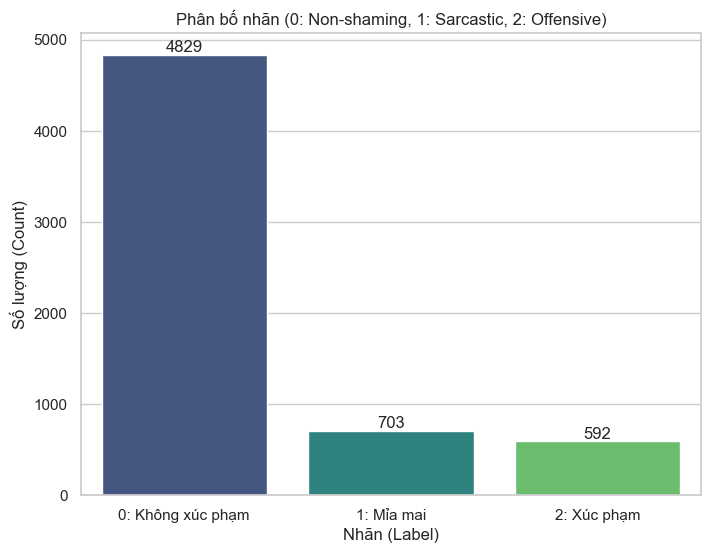

✅ Đã lưu ảnh: sentence_length.png


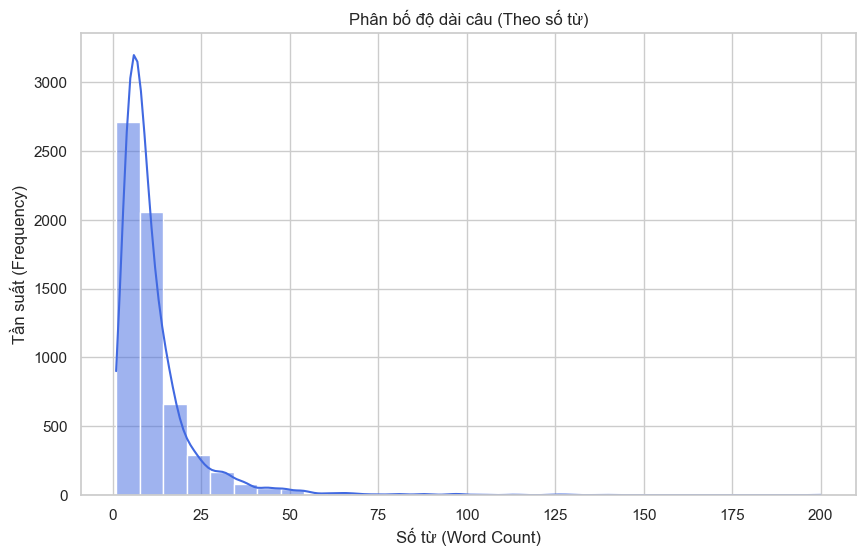


--- SỐ LIỆU BÁO CÁO ---
Tổng số dòng dữ liệu: 6124

Tỷ lệ phân bố nhãn (%):
label_id
0    78.853690
1    11.479425
2     9.666884
Name: proportion, dtype: float64

Thống kê độ dài câu:
- Trung bình: 11.55 từ
- Ngắn nhất: 1 từ
- Dài nhất: 200 từ


In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- CẤU HÌNH ---
FILE_PATH = os.path.join('..', 'data', 'raw', 'dataset_raw.csv')

try:
    # 1. Đọc dữ liệu (thêm encoding='utf-8-sig' để đọc tiếng Việt không lỗi)
    if FILE_PATH.endswith('.xlsx'):
        df = pd.read_excel(FILE_PATH)
    else:
        df = pd.read_csv(FILE_PATH, encoding='utf-8-sig')

    print("✅ Đã đọc file thành công!")

    # 2. Xử lý sơ bộ (Xóa dòng trống nếu có)
    # Loại bỏ các dòng mà cột label hoặc comment_text bị trống
    df = df.dropna(subset=['label', 'comment_text'])

    # 3. MAPPING NHÃN (Tự động chuyển chữ sang số để vẽ)
    # Chuẩn hóa text trong cột label (xóa khoảng trắng thừa đầu đuôi)
    df['label'] = df['label'].astype(str).str.strip()

    # Dictionary ánh xạ (Dựa trên screenshot và tài liệu của bạn)
    label_mapping = {
        'Không xúc phạm': 0,
        'Mỉa mai': 1,
        'Xúc phạm': 2
    }

    # Tạo cột label_id mới (dạng số)
    df['label_id'] = df['label'].map(label_mapping)

    # Kiểm tra xem có nhãn nào bị sót không (VD: gõ sai chính tả)
    missing_labels = df[df['label_id'].isna()]['label'].unique()
    if len(missing_labels) > 0:
        print(f"⚠️ CẢNH BÁO: Các nhãn sau không map được (kiểm tra chính tả): {missing_labels}")
        # Tạm thời điền -1 cho các nhãn lỗi để code không crash
        df['label_id'] = df['label_id'].fillna(-1)

    # --- VẼ BIỂU ĐỒ 1: PHÂN BỐ NHÃN (LABEL DISTRIBUTION) ---
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x='label_id', data=df, palette='viridis')
    
    plt.title('Phân bố nhãn (0: Non-shaming, 1: Sarcastic, 2: Offensive)')
    plt.xlabel('Nhãn (Label)')
    plt.ylabel('Số lượng (Count)')
    plt.xticks([0, 1, 2], ['0: Không xúc phạm', '1: Mỉa mai', '2: Xúc phạm']) # Gắn nhãn trục X cho dễ đọc

    # Hiển thị số lượng trên cột
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='bottom')

    plt.savefig('label_distribution.png') # Lưu ảnh
    print("✅ Đã lưu ảnh: label_distribution.png")
    plt.show()

    # --- VẼ BIỂU ĐỒ 2: ĐỘ DÀI CÂU (SENTENCE LENGTH) ---
    # Tính số từ
    df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

    plt.figure(figsize=(10, 6))
    sns.histplot(df['word_count'], bins=30, kde=True, color='royalblue')
    plt.title('Phân bố độ dài câu (Theo số từ)')
    plt.xlabel('Số từ (Word Count)')
    plt.ylabel('Tần suất (Frequency)')
    
    plt.savefig('sentence_length.png') # Lưu ảnh
    print("✅ Đã lưu ảnh: sentence_length.png")
    plt.show()

    # --- IN THỐNG KÊ ĐỂ VIẾT BÁO CÁO ---
    print("\n--- SỐ LIỆU BÁO CÁO ---")
    print("Tổng số dòng dữ liệu:", len(df))
    print("\nTỷ lệ phân bố nhãn (%):")
    print(df['label_id'].value_counts(normalize=True).sort_index() * 100)
    print("\nThống kê độ dài câu:")
    print(f"- Trung bình: {df['word_count'].mean():.2f} từ")
    print(f"- Ngắn nhất: {df['word_count'].min()} từ")
    print(f"- Dài nhất: {df['word_count'].max()} từ")

except FileNotFoundError:
    print("❌ Lỗi: Không tìm thấy file. Hãy kiểm tra lại tên file và đường dẫn.")
except Exception as e:
    print(f"❌ Lỗi không xác định: {e}")

EDA Phase 2 (Content Analysis)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import os

# --- CẤU HÌNH ---
# 1. Đường dẫn file đã xử lý (Check kỹ tên file trong folder data/processed/)
INPUT_FILE = os.path.join('..', 'data', 'processed', 'train_stat.csv')

# 2. Đường dẫn Font chữ tiếng Việt (RẤT QUAN TRỌNG)
# Nếu dùng Windows: 'C:/Windows/Fonts/arial.ttf'
# Nếu dùng Macbook: '/Library/Fonts/Arial Unicode.ttf' hoặc tải file font tiếng Việt để vào cùng thư mục code
FONT_PATH = 'C:/Windows/Fonts/arial.ttf' # <--- SỬA LẠI CHO ĐÚNG MÁY BẠN

# --- HÀM VẼ WORDCLOUD ---
def plot_wordcloud(text_data, title):
    try:
        wc = WordCloud(
            background_color='white',
            width=800, height=400,
            font_path=FONT_PATH,  # Phải có cái này mới hiện tiếng Việt
            max_words=100
        ).generate(str(text_data))

        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=15)
        plt.show()
    except Exception as e:
        print(f"Lỗi vẽ WordCloud (thường do sai đường dẫn font): {e}")

# --- HÀM VẼ TOP N-GRAMS ---
def plot_top_ngrams(corpus, title, n=2, top_k=10):
    # n=2 là Bigram (cụm 2 từ), n=3 là Trigram
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    # Lấy top k
    df_ngram = pd.DataFrame(words_freq[:top_k], columns=['Ngram', 'Count'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='viridis')
    plt.title(title)
    plt.show()

# --- CHẠY CHƯƠNG TRÌNH ---
try:
    # 1. Load dữ liệu sạch
    print(f"Đang đọc file: {INPUT_FILE}...")
    df = pd.read_csv(INPUT_FILE, encoding='utf-8-sig')
    
    # Chuyển cột text về string để tránh lỗi
    df['comment_text'] = df['comment_text'].astype(str)

    # 2. Vòng lặp vẽ cho từng nhãn (0, 1, 2)
    labels = {0: 'Không xúc phạm', 1: 'Mỉa mai', 2: 'Xúc phạm'}
    
    for label_code, label_name in labels.items():
        print(f"\n--- ĐANG XỬ LÝ NHÃN: {label_name.upper()} ---")
        
        # Lọc dữ liệu theo nhãn
        subset = df[df['label'] == label_code]
        text_corpus = subset['comment_text']
        
        if len(text_corpus) > 0:
            # Vẽ WordCloud
            plot_wordcloud(text_corpus.str.cat(sep=' '), f"WordCloud - {label_name}")
            
            # Vẽ Top 10 Bigrams (2 từ đi liền nhau)
            plot_top_ngrams(text_corpus, f"Top 10 Cụm từ (Bigrams) - {label_name}", n=2)
        else:
            print(f"Không có dữ liệu cho nhãn {label_name}")

except FileNotFoundError:
    print("❌ Lỗi: Không tìm thấy file train_stat.csv. Hãy nhắc bạn Ngọc chạy file pre_2.py trước!")

Đang đọc file: ../data/processed/train_stat.csv...
❌ Lỗi: Không tìm thấy file train_stat.csv. Hãy nhắc bạn Ngọc chạy file pre_2.py trước!
